In [3]:
## This notebook takes the outputs of DeSeq2 and collates them for analysis as well as TPM values. The formatting is a little wonky, sorry 
## about that. If you want to run DeSeq2 from raw counts data ____ 

## Plots generated in this notebook are used to make Figures 6D&E, S6A-H

In [ ]:
## Import modules

import pandas as pd 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import gseapy as gp
import scipy as sp
import seaborn as sns
from scipy import stats
#from matplotlib_venn import venn2, venn2_circles

In [4]:
## All files available at: https://app.box.com/folder/171917844113?s=nuwov4kgb55mqfrr7j5a216ot78f4uxn


## Import data

## Define a table that will be used to transform ENSG identifiers to gene names
#ensg_csv_table = pd.read_csv('../ENSG_to_name.csv',index_col=0)
ensg_csv_table = pd.read_csv('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/Methods/ENSG_to_name.csv',index_col=0)

## Import the ref1 and ATRi gene level maps
dmso1_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S3.xlsx',index_col = 0)
atr_map = pd.read_excel('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/herken2023_materials/figures/herken23_supp_data/Data_S4.xlsx',index_col = 0)

## Import raw counts data from RNAseq
read_table = pd.read_csv('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/Nua4RNAseq/expt4/rnaseq4_K562counts.txt',sep='\t',index_col = 0)


In [5]:
## collateDeseq is a function that takes a directory whose contents include only .xlsx files in the format and 
## naming convention of the output from the notebook "deseq2_ensg_to_hits.ipynb". The function also takes the cell 
## type to be analyzed, which should appear as the sub directory header in the main directory. 
## The function outputs two dataframes. Both have indexes equal to all genes in genome (in ensg format). "outDf" has the
## differential expression value of each gene, "sigDf" has the adjusted p-value of each gene.

def collateDeseq(directory,cellType):
    for i,file in enumerate(os.listdir(directory+'/'+cellType)):
        if file == '.DS_Store':
            continue
        root = file.split(cellType+'_')[1].split('.csv')[0]
        print(file,root)
        if i == 0:
            start = pd.read_csv(directory+'/'+cellType+'/'+file,index_col=0)  
            outDf = pd.DataFrame(index=start.index)
            sigDf = pd.DataFrame(index=start.index)
            outDf[root] = start['log2FoldChange']
            sigDf[root] = start['padj']
        if i != 0:
            outDf[root] = pd.read_csv(directory+'/'+cellType+'/'+file,index_col=0)['log2FoldChange']  
            sigDf[root] = pd.read_csv(directory+'/'+cellType+'/'+file,index_col=0)['padj']
    return outDf,sigDf

## a function to transform ENSG identifiers to gene names
def ensg_to_gene(ensg_list):
    out_list = []
    for item in ensg_list:
        ensg = item.split('.')[0]
        if ensg in ensg_csv_table.index:
            out_list.append(ensg_csv_table.loc[ensg,'gene'])
        else:
            out_list.append(ensg)
    return out_list

## The function "deconstruct_tree"  will take an integer value representing a branch point of a hierarchical clustering and a distance matrix
## for that clustering. An empty list called "branch_identity" MUST be defined before this function can run. The function populates 
## branch_identity with all of the individual leafs that are contained within the branch point identified.
def deconstruct_tree(start,tree):
    node = tree[start]
    if node[0] > len(tree):
        deconstruct_tree(int(node[0]-(len(tree)+1)),tree)
    if node[0] <= len(tree):
        branch_identity.append(node[0])
    if node[1] > len(tree):
        deconstruct_tree(int(node[1]-(len(tree)+1)),tree)
    if node[1] <= len(tree):
        branch_identity.append(node[1])

## cluster_thresh takes a distance matrix and a distance threshold and iterate through branch points in the distance matrix until you hit the
## threshold. It will populate a list with the highest order clusters formed under the threshold.
def cluster_thresh(distance_matrix,distance_thresh):
    out_list = []
    for i,branch in enumerate(distance_matrix):
        if branch[2] > distance_thresh:
            break
        if branch[0] in out_list:
            out_list.remove(branch[0])
        if branch[1] in out_list:
            out_list.remove(branch[1])
        out_list.append(i+(len(distance_matrix)+1))   
    return out_list

In [53]:
## collate DeSeq2 results into LFC and p-val dataframes. In order to do this, grab the folder "../RNAseq_files/DeSeq_output/K562" from:
## https://app.box.com/folder/171917844113?s=nuwov4kgb55mqfrr7j5a216ot78f4uxn 
## Then, as the first arguement in 'collateDeseq', path to the directory above your "K562" library

#deseq_results_K562,sig_results_K562 = collateDeseq('../DeSeq_output','K562')
deseq_results_K562,sig_results_K562 = collateDeseq('/Users/benh/Desktop/UCSF_Tetrad_Program/Gilbert_Lab/Nua4RNAseq/expt4/results','K562')

K562_sgDMAP1_T-vs-sgNEG_UT2.csv sgDMAP1_T-vs-sgNEG_UT2
K562_sgBRD8_UT-vs-sgNEG_UT2.csv sgBRD8_UT-vs-sgNEG_UT2
K562_sgBRD8_T-vs-sgNEG_UT2.csv sgBRD8_T-vs-sgNEG_UT2
K562_sgDMAP1_UT-vs-sgNEG_UT2.csv sgDMAP1_UT-vs-sgNEG_UT2
K562_sgNEG_T-vs-sgNEG_UT2.csv sgNEG_T-vs-sgNEG_UT2


In [7]:
## Set the counts index to gene names rather than ensg
read_table.index = ensg_to_gene(read_table.index)

## TPM normalize the data
for i,col in enumerate(read_table.columns):
    read_table.iloc[:,i] = (read_table.iloc[:,i]/read_table.iloc[:,i].sum())*1e6

In [10]:
## Make a power matrix of all genes across all experiments, by taking the product of the -log10pval and LFC for each gene
power_results_K562 = -np.log10(sig_results_K562)*deseq_results_K562
power_results_K562 = power_results_K562[['sgNEG_T-vs-sgNEG_UT2','sgBRD8_UT-vs-sgNEG_UT2','sgBRD8_T-vs-sgNEG_UT2','sgDMAP1_UT-vs-sgNEG_UT2','sgDMAP1_T-vs-sgNEG_UT2']]

## Make and populate a power hit list, where if a gene has a power score greater than a threshold in any comparison
## In this dataset, it is include to the list
thresh = 10
power_hit_list = []

for x in power_results_K562.index:
    for y in power_results_K562.columns:
        if abs(power_results_K562.loc[x,y]) > thresh:
            if x not in power_hit_list:
                power_hit_list.append(x)
power_hit_list = ensg_to_gene(power_hit_list)

In [8]:
## Make a dictionary to map the titles in the read table to the readable experimental condition
map_dict = {
    'BRD8_UT':['96_r1_UT_K','96_r2_UT_K'],
    'BRD8_T' : ['96_r1_T_K','96_r2_T_K'],
    'DMAP1_UT' : ['98_r1_UT_K','98_r2_UT_K'],
    'DMAP1_T' : ['98_r1_T_K','98_r2_T_K'],
    'NEG_UT' : ['100_r1_UT_K','100_r2_UT_K'],
    'NEG_T' : ['100_r1_T_K','100_r2_T_K'],
}


In [12]:
## Make a matrix of TPM values of genes from the power hit list against each condition in the experiment
power_tpm_list = read_table.loc[power_hit_list]

## Make and populate a DF with the average TPM value of power_hit genes across the two replicates in each condition
power_tpm_df = pd.DataFrame(index = power_tpm_list.index)
for cond in map_dict.keys():
    power_tpm_df[cond] = power_tpm_list.loc[:,map_dict[cond]].mean(axis = 1)

In [60]:
## Rename the index so that it includes genes names

deseq_results_K562.index = ensg_to_gene(deseq_results_K562.index)
sig_results_K562.index = ensg_to_gene(sig_results_K562.index)
power_results_K562.index = ensg_to_gene(power_results_K562.index)


In [14]:
## Make a new dataframe that only includes hit genes from power_hit_list, then replace nan with zero
power_hits_df = power_results_K562.loc[power_hit_list,:]
power_hits_df = power_hits_df.fillna(0)

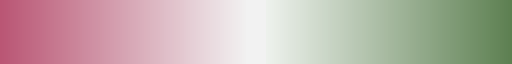

In [15]:
## Make a colormap for power values
power_cmap = sns.diverging_palette(356, 120, s=50, l=50, sep=10, n=100, center="light",as_cmap= True)
power_cmap

In [16]:
## Reorder the columns in a way that makes more sense to me
power_hits_df_trim = power_hits_df.loc[:,['sgNEG_T-vs-sgNEG_UT2','sgDMAP1_UT-vs-sgNEG_UT2','sgDMAP1_T-vs-sgNEG_UT2','sgBRD8_UT-vs-sgNEG_UT2','sgBRD8_T-vs-sgNEG_UT2']]


(0.0, 200.0)

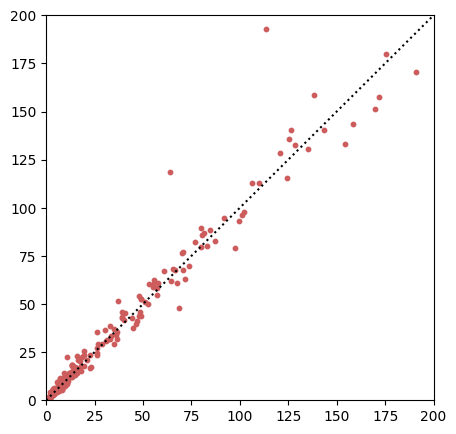

In [37]:
## Plot replicate averaged TPM values for all genes from our power hit list for any two conditions

plt.figure(figsize = (5,5))
plt.scatter(power_tpm_df['BRD8_UT'],power_tpm_df['BRD8_T'],s = 10, color = 'indianred' )
plt.plot((0,200),(0,200),':',color = 'black')
plt.xlim(0,200)
plt.ylim(0,200)


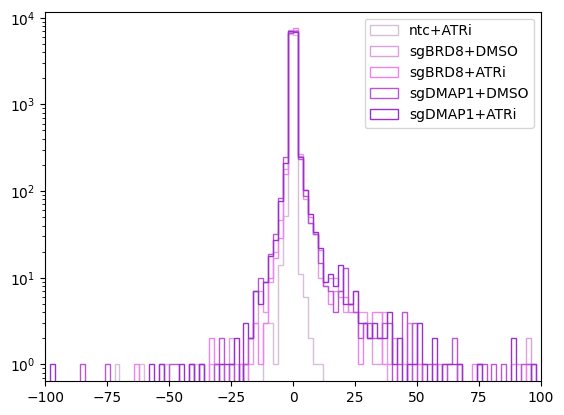

In [38]:
## Makes overlapping histrograms of power values for all genes across the five comparisons

colors = ['thistle','plum','violet','mediumorchid','darkorchid']
samples = ['ntc+ATRi','sgBRD8+DMSO','sgBRD8+ATRi','sgDMAP1+DMSO','sgDMAP1+ATRi']

for i,col in enumerate(power_results_K562.columns):
    plt.hist(power_results_K562[col],bins=100,histtype='step',log=True, color =colors[i],label = samples[i],range = (-100,100))
plt.xlim(-100,100)
plt.legend()
#plt.savefig('/Users/benh/Desktop/deseq_power_allgenes_hist.png',dpi=300)

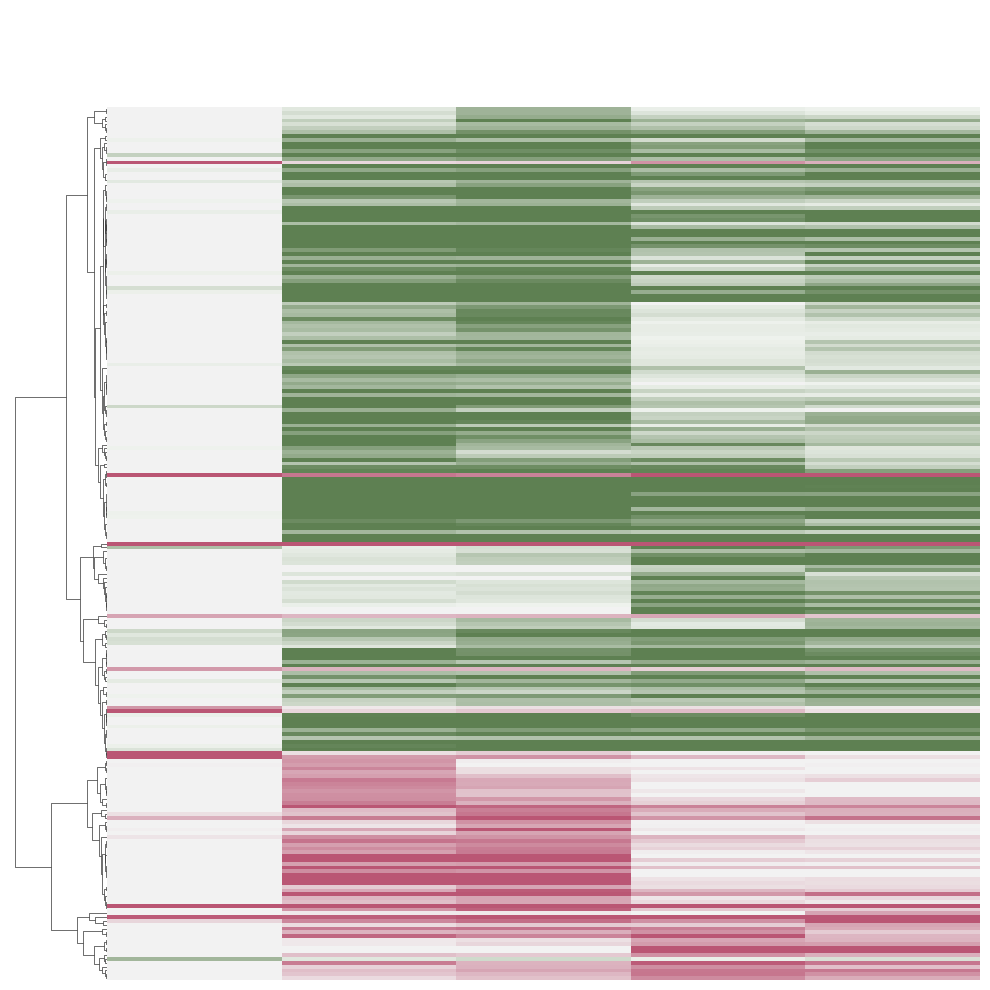

In [39]:
## Cluster the matrix of all power threshold passed genes across the five comparisons
power_clustered = sns.clustermap(power_hits_df_trim,
               col_cluster = False,
               vmin=-20,vmax=20,
              cmap= power_cmap,
              method='average',
               metric='correlation',
               xticklabels=False,
               yticklabels=False,
               #row_colors = color_df,
               cbar_pos= None,
               dendrogram_ratio= 0.1
              )
#plt.savefig('/Users/benh/Desktop/power_heatmap.png',dpi = 300)

In [50]:
## Reorganize the Df index based on the clustering
power_ordered = power_hits_df_trim.iloc[power_clustered.dendrogram_row.reordered_ind,:]

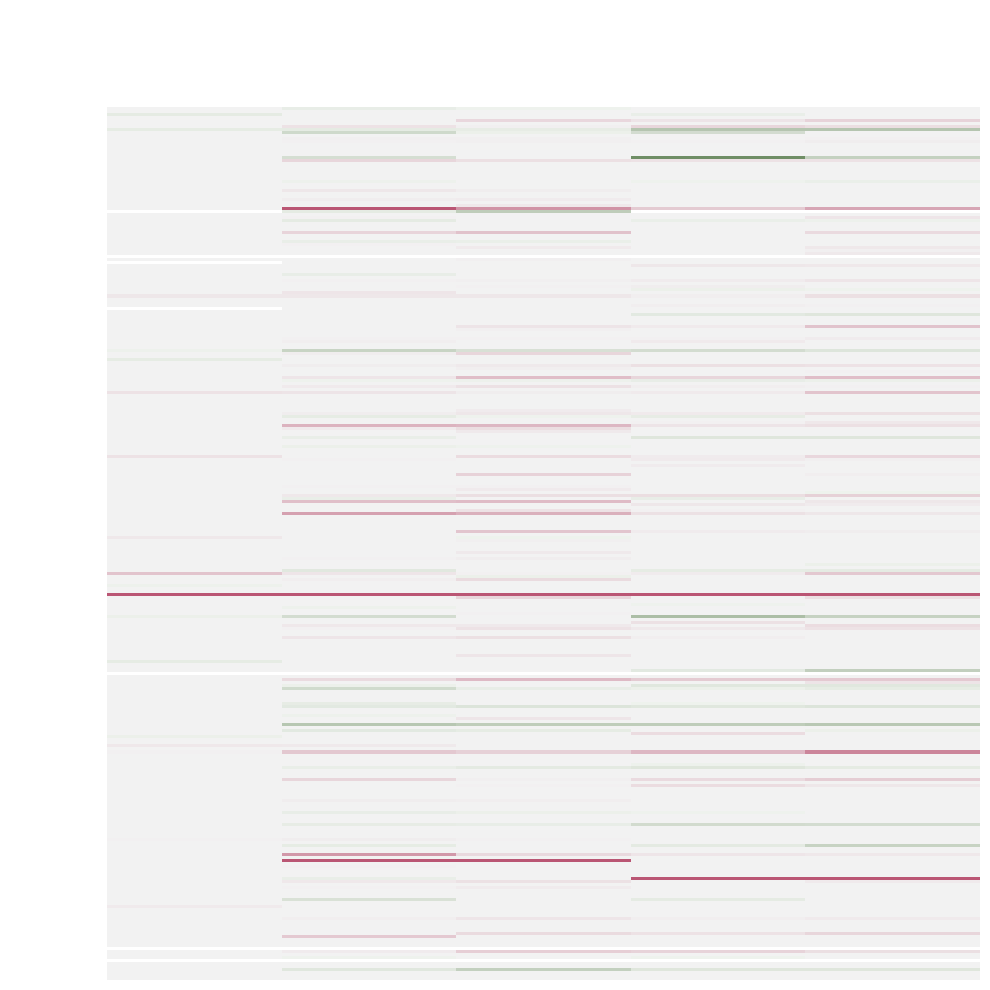

In [40]:
## Cluster all power values across the five comparisons for the subset of genes in our GI library
sns.clustermap(power_results_K562.loc[[item for item in atr_map.index if item in power_results_K562.index]],
               row_cluster = False,
               col_cluster = False,
               vmin=-5,vmax=5,
              cmap= power_cmap,
              method='average',
               metric='correlation',
               xticklabels=False,
               yticklabels=False,
              # row_colors = color_df,
               cbar_pos= None,
               dendrogram_ratio= 0.1
              )
##plt.savefig('/Users/benh/Desktop/deseq_power_gigenes.png',dpi=300)

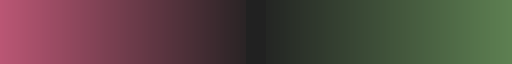

In [42]:
## A second power cmap with a dark center
power_cmap2 = sns.diverging_palette(356, 120, s=50, l=50, sep=10, n=100, center="dark",as_cmap= True)
power_cmap2

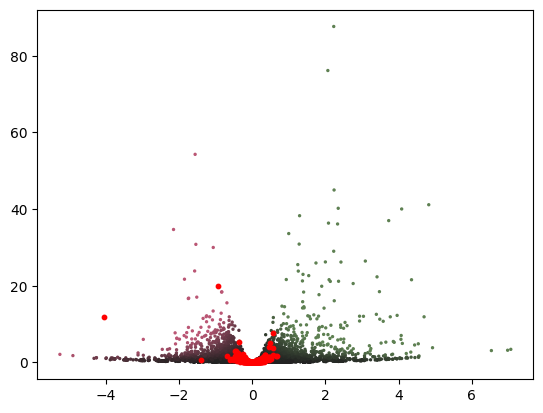

In [43]:
## Make volcano plots for LFC -vs- -log10 pval for the five comparisons. Highlight genes using the power cmap based on their power value
## Also, color all genes in our GI library as red. 
cond = 'sgDMAP1_UT-vs-sgNEG_UT2'

plt.scatter(deseq_results_K562[cond],-np.log10(sig_results_K562[cond]),
            s = 2, 
            cmap = power_cmap2, 
            c = -np.log10(sig_results_K562[cond]).values * deseq_results_K562[cond].values,
           vmin = -10,vmax = 10)

overlap = list(set(deseq_results_K562.index).intersection(dmso1_map.index))
plt.scatter(deseq_results_K562.loc[overlap,cond],
           -np.log10(sig_results_K562.loc[overlap,cond]),s=10,color = 'red')
#plt.savefig('/Users/benh/Desktop/deseq_dex_dmap1_liboverlap.png',dpi=300)

Text(0, 0.5, 'TPM')

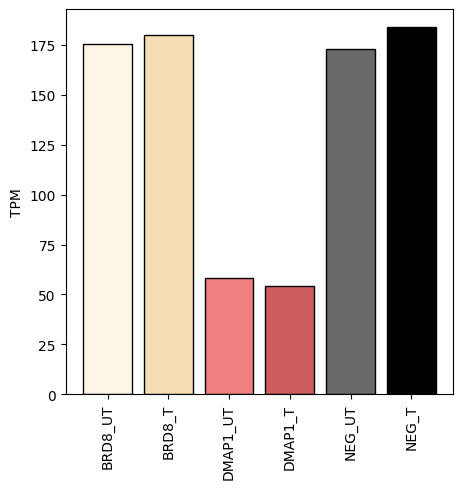

In [45]:
## Define a gene to analyze its TPM values across the six experiments
gene = 'BECN1'
plt.figure(figsize=(5,5))
plt.xticks(rotation=90)

plt.bar(range(len(power_tpm_df.columns)),power_tpm_df.loc[gene,:],
        tick_label = power_tpm_df.columns,
       color = ['oldlace','wheat','lightcoral','indianred','dimgray','black'],
       edgecolor = 'black')
plt.ylabel('TPM')
#plt.savefig('/Users/benh/Desktop/herken23_main_figs resub/deseq_plots/'+str(gene)+'_bar.png',dpi=300)

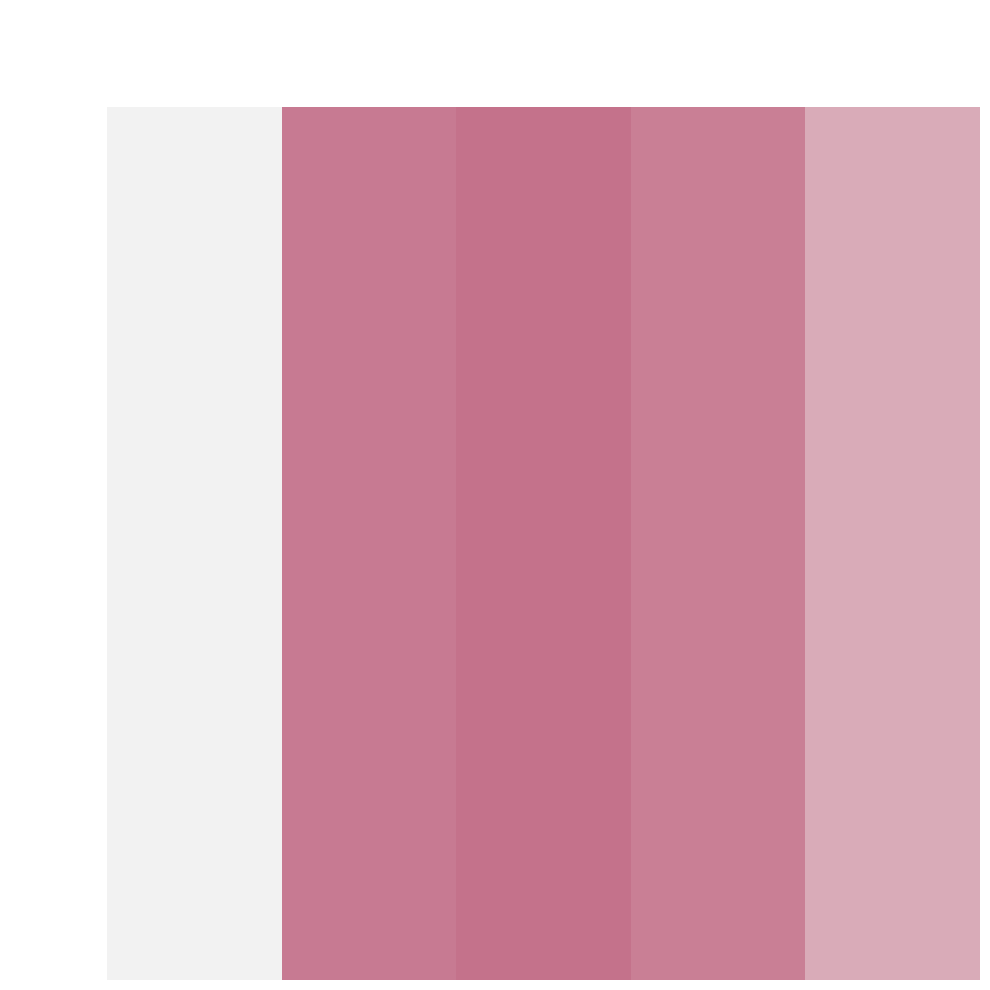

In [52]:
## Use this cell to draw slices of the ordered power hits dataframe
gl = ['NFKBIA']
sns.clustermap(power_ordered.loc[gl],
               row_cluster = False,
               col_cluster = False,
               vmin=-20,vmax=20,
              cmap= power_cmap,
              method='average',
               metric='correlation',
               xticklabels=False,
               yticklabels=False,
              # row_colors = color_df,
               cbar_pos= None,
               dendrogram_ratio= 0.1
              )
#plt.savefig('/Users/benh/Desktop/power_cluster_4.png',dpi=300)

In [83]:
## Make the ATR dGI map
atr_di_map = atr_map - dmso1_map

## Define TIP60 genes
tip60 = ['BRD8','TRRAP','EP400','DMAP1','MRGBP','EPC2']

## grab the ATRi induced LFC data for the genes in our library
overlap = [item for item in deseq_results_K562.index if item in atr_di_map.index]
## Find the  average absolute dGI score for all genes in overlap, also grab their LFC from the ntc_ATRi-vs-ntc_DMSO comparison
abavg_dgi = []
tip60_dgi = []
lfc = []
for gene in overlap:
    abavg_dgi.append(np.mean(abs(atr_di_map[gene])))
    if gene in tip60:
        tip60_dgi.append(np.mean(abs(atr_di_map[gene])))



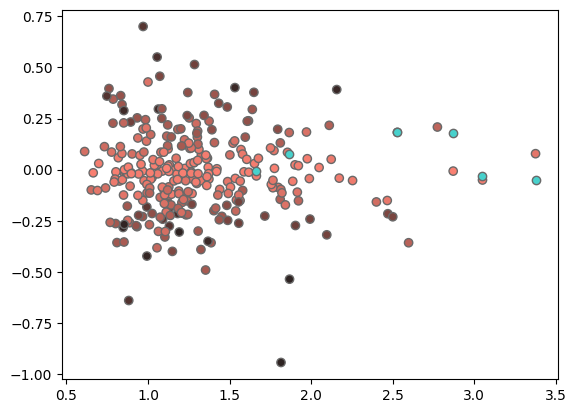

In [87]:
## Plot the absolute average dGI score for every gene in our library against that gene's ATRi induced LFC. Also, highlight the TIP60 genes in
## out library. Color them accordingly to their pvalue, with darker colors being more significant in this case

cmap = sns.color_palette("dark:salmon", as_cmap=True)
plt.scatter(abavg_dgi,deseq_results_K562.loc[overlap,'sgNEG_T-vs-sgNEG_UT2'],
            cmap = cmap,c= sig_results_K562.loc[overlap,'sgNEG_T-vs-sgNEG_UT2'],
           edgecolors = 'dimgray')

plt.scatter(tip60_dgi,deseq_results_K562.loc[tip60,'sgNEG_T-vs-sgNEG_UT2'], color = 'mediumturquoise',edgecolor = 'dimgray')